Successfully processed w2_35cntrl:
GrowthRates 6.2 ©2022 All Rights Reserved Bellingham Research Institute.


	1.	Input file is already in Standard format
	2	Biotek Eon
	3.	Biotek PowerWave HT
	4.	Perkin Elmer
	5.	Bioscreen
	6.	Spark Tecan
	7.	SpectraMax or SpectraMaxM2
	8.	SpectroStarNano
	9.	Tecan
	10.	FLUOstar Omega
	11.	SpectraMaxPlus384 or M5
	12.	Biotek Cytation5 or Epoch2
	13.	Tecan Infinite 200 Pro
	14.	Synergy HTX
	15.	Growth Profiler 960
	16	Cerillo Stratus.
	17	Thermofisher Varioskan-LUX.
	18	Biotek 800 TS.

	0.	None of the above.


Pick your plate reader from the menu above and enter the corresponding number

You have chosen Standard.  Is that correct? (Y or N) 

The format is Standard.

Successfully processed w3_rep2:
GrowthRates 6.2 ©2022 All Rights Reserved Bellingham Research Institute.


	1.	Input file is already in Standard format
	2	Biotek Eon
	3.	Biotek PowerWave HT
	4.	Perkin Elmer
	5.	Bioscreen
	6.	Spark Tecan
	7.	SpectraMax or SpectraMaxM2
	8.	SpectroStarNano
	9.

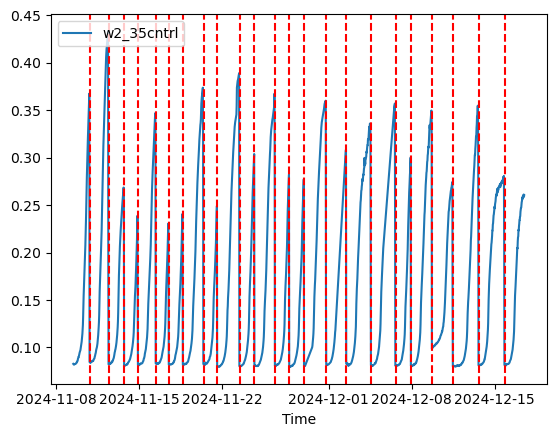

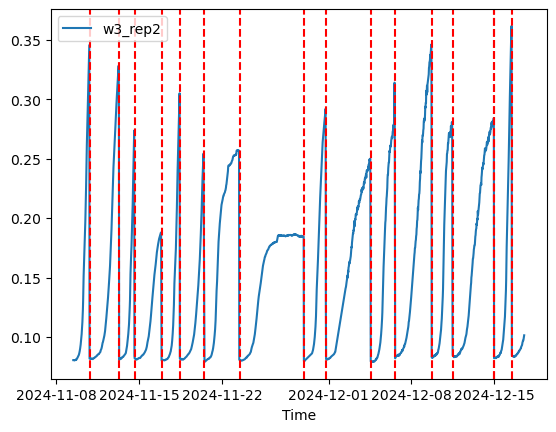

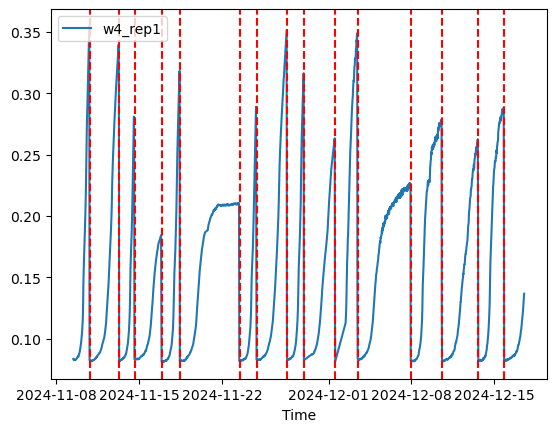

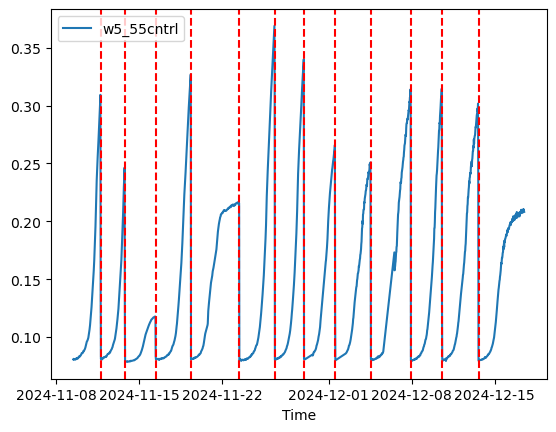

In [1]:
import os
import subprocess
import pandas as pd
import glob
import os
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Path to your .exec file
growth_rates_exec_path = '/Users/jackson/Library/CloudStorage/OneDrive-UW/University of Washington/deming_lab/switching_salinity/GrowthRates'

# Output directory for worker files (relative path)
output_dir = './grme/'
os.makedirs(output_dir, exist_ok=True)  # Ensure the directory exists

def unzip_and_rename_csv(zip_file, extract_folder=None, new_name="latest_od_data.csv"):
    """
    Extracts a CSV from a ZIP file, renames it, and returns its path.
    """
    extract_folder = extract_folder or os.path.dirname(zip_file)
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_folder)
        csv_file = next((os.path.join(extract_folder, f) for f in zip_ref.namelist() if f.lower().endswith('.csv')), None)
    if not csv_file:
        raise FileNotFoundError("No CSV found in the ZIP.")
    renamed_path = os.path.join(extract_folder, new_name)
    os.rename(csv_file, renamed_path)
    return renamed_path

# Load the most recent CSV or extract from ZIP
csv_files = glob.glob(os.path.expanduser('~/Downloads/*.csv'))
latest_csv = max(csv_files, key=os.path.getmtime) if csv_files else unzip_and_rename_csv('./od_logs/latest_od_data.zip')
exp1_csv = unzip_and_rename_csv('./od_logs/exp1.zip', new_name="exp1.csv")

# Load and preprocess data
def preprocess_csv(file_path):
    """Load and preprocess CSV data."""
    return (
        pd.read_csv(file_path)
        .rename(columns={"od_reading": "OD600", "timestamp_localtime": "Time", "pioreactor_unit": "Unit"})
        .drop(columns=["experiment", "timestamp", "angle", "channel"])
        .assign(Time=lambda d: pd.to_datetime(d["Time"]))
    )

df = pd.concat([preprocess_csv(latest_csv), preprocess_csv(exp1_csv)])
df = df.drop_duplicates(subset=['Time', 'Unit'])  # Remove duplicates

# Pivot for analysis
df = df.pivot(index='Time', columns='Unit', values='OD600')

# Remove the 'Unit' name from columns
df.columns.name = None

# Apply transformations
transformations = {
    'worker2': (1.3486, 0.077),
    'worker3': (2.0737, 0.077),
    'worker4': (2.2043, 0.077),
    'worker5': (1.1695, 0.077)
}

for unit, (slope, intercept) in transformations.items():
    if unit in df.columns:
        df[unit] = df[unit] * slope + intercept

# Filter out datapoints above 0.45
df = df[df < 0.45]
df = df[100:]

df = df.rename(columns={"worker2": "w2_35cntrl", "worker3" : "w3_rep2", "worker4": "w4_rep1", "worker5" : "w5_55cntrl"})
# Loop through workers in the DataFrame
for worker in df.columns:
    # Generate the worker output file
    worker_file = os.path.join(output_dir, f"{worker}.txt")
    new_data = pd.DataFrame()

    # Pre-identified subculture points for this worker
    data = df[[worker]].resample('30min').mean()
    subculture_points = (
        data.loc[data[worker].rolling(3).std().abs() > 0.02]
        .groupby(data.loc[data[worker].rolling(3).std().abs() > 0.02].index.date)
        .idxmin()
        .reset_index(drop=True)
        .to_numpy()
        .flatten()
    )

    fig, ax = plt.subplots()
    sns.lineplot(data=data)
    # Draw a vertical line at x = 2
    for i in range(len(subculture_points)):
        plt.axvline(x=subculture_points[i], color='red', linestyle='--')
    plt.legend(loc='upper left')



    data = df[[worker]].resample('10min').mean()
    start_index = data.index[0]

    for i, point in enumerate(subculture_points):
        current_step = data.loc[start_index:point]
        if not current_step.empty:
            current_step = current_step.iloc[:-6]
            if not current_step.empty:
                current_step.index = ((current_step.index - current_step.index[0]).total_seconds() / 60).astype(int)
                current_step.columns = [f'{worker}_S{i+1}']
                new_data = pd.concat([new_data, current_step], axis=1)
        if i == len(subculture_points) - 1:
            break
        start_index = point

    new_data.index.name = 'Min'
    new_data = new_data.interpolate(method='linear', limit_area='inside').round(4).fillna(0)

    # Save the processed worker data to a file
    new_data.to_csv(worker_file, sep='\t')

    # Call the GrowthRates .exec file
    relative_worker_file = os.path.relpath(worker_file)  # Make the path relative
    command = [growth_rates_exec_path, "-i", relative_worker_file, "-b", "0.077"]

    try:
        # Use Popen to handle interactive input
        process = subprocess.Popen(
            command,
            stdin=subprocess.PIPE,
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True
        )
        # Provide the responses for the prompts
        responses = "1\nY\n"  # First question: "1", Second question: "Y"
        stdout, stderr = process.communicate(input=responses)

        # Check the process results
        if process.returncode == 0:
            print(f"Successfully processed {worker}:\n{stdout}")
        else:
            print(f"Error processing {worker}:\n{stderr}")

    except Exception as e:
        print(f"Error running GrowthRates for {worker}: {e}")

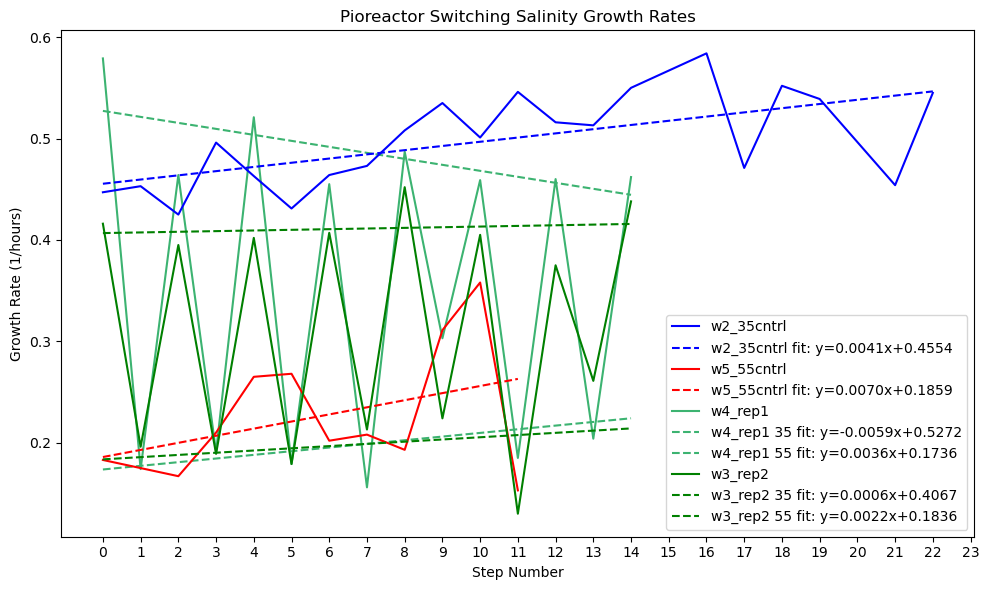

In [2]:

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import os

# Initialize the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Define color palette and categories
palette = {'w2_35cntrl': "blue", 'w5_55cntrl': "red", 'w3_rep2': "green", 'w4_rep1': "mediumseagreen"}
replicates = ['w3_rep2', 'w4_rep1']
controls = ['w2_35cntrl', 'w5_55cntrl']

# Store legend handles and labels to customize order
legend_entries = []

# Process and plot each CSV file
csv_files = glob.glob(os.path.expanduser('grme/*.summary'))
for filepath in csv_files:
    # Load data from the file
    temp_df = pd.read_csv(filepath, sep='\t', header=2, usecols=['Well', 'min', 'hours', 'R', 'Max OD', 'lag time (minutes)'])
    temp_df.rename(columns={'hours': 'Growth Rate (1/hours)'}, inplace=True)
    unit_name = os.path.basename(filepath).split('.')[0]

    # remove S16 and S19 for w2_35cntrl
    if unit_name == 'w2_35cntrl':
        temp_df.drop([15, 20], inplace=True)

    # Check if the unit is in replicates or controls
    if unit_name in replicates:
        line = sns.lineplot(data=temp_df, x=temp_df.index, y='Growth Rate (1/hours)', ax=ax, color=palette[unit_name], label=unit_name)

        # Fit and plot best-fit lines for odd and even steps
        x = temp_df.index
        y = temp_df['Growth Rate (1/hours)']
        if len(x[::2]) > 1:  # Check to ensure there are enough points for fitting
            m_odd, b_odd = np.polyfit(x[::2], y[::2], 1)
            ax.plot(x, m_odd * x + b_odd, color=palette[unit_name], linestyle='dashed', label=f'{unit_name} 35 fit: y={m_odd:.4f}x+{b_odd:.4f}')
        if len(x[1::2]) > 1:
            m_even, b_even = np.polyfit(x[1::2], y[1::2], 1)
            ax.plot(x, m_even * x + b_even, color=palette[unit_name], linestyle='dashed', label=f'{unit_name} 55 fit: y={m_even:.4f}x+{b_even:.4f}')

    elif unit_name in controls:
        line = sns.lineplot(data=temp_df, x=temp_df.index, y='Growth Rate (1/hours)', ax=ax, color=palette[unit_name], label=unit_name)

        # Fit and plot single best-fit line
        x = temp_df.index
        y = temp_df['Growth Rate (1/hours)']
        if len(x) > 1:
            m, b = np.polyfit(x, y, 1)
            ax.plot(x, m * x + b, color=palette[unit_name], linestyle='dashed', label=f'{unit_name} fit: y={m:.4f}x+{b:.4f}')

# Set axis limits, labels, and title
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, end, 1))
plt.xlabel('Step Number')
plt.ylabel('Growth Rate (1/hours)')
plt.title('Pioreactor Switching Salinity Growth Rates')
plt.tight_layout()
plt.legend(loc='lower right')
handles, labels = plt.gca().get_legend_handles_labels()
order = [8, 9, 3, 4, 0, 1, 2, 5, 6, 7]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
plt.show()